# Ejercicio Regression Tree
Son datos de temperaturas tomados de la ciudad de Seattle. El objetivo es intentar predecir lo mejor posible la máxima temperatura (columna `actual`) que alcanzaremos al día siguiente. Para ello contaremos con temperaturas de los dos días anteriores, históricos de máximas temperaturas y un amigo bastante chapas que te da su predicción del tiempo cada día.

**Resumen de datos**:
* year: 2016 for all data points
* month: number for month of the year
* day: number for day of the year
* week: day of the week as a character string
* temp_2: max temperature 2 days prior
* temp_1: max temperature 1 day prior
* average: historical average max temperature
* actual: max temperature measurement
* friend: your friend’s prediction, a random number between 20 below the average and 20 above the average


### 1. Importa el csv "temps.csv"

In [108]:
import numpy as np
import pandas as pd
import sklearn
# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14) #Está controlando el tamaño de las etiquetas
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

In [109]:
df = pd.read_csv("data/temps.csv")
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


variable target (y) --> **actual**

### 2. Realiza un análisis exploratorio junto con un Feature Engineering

In [110]:
df.info() #vemos que la variable "week" es un objeto (no se le da importancia)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [111]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


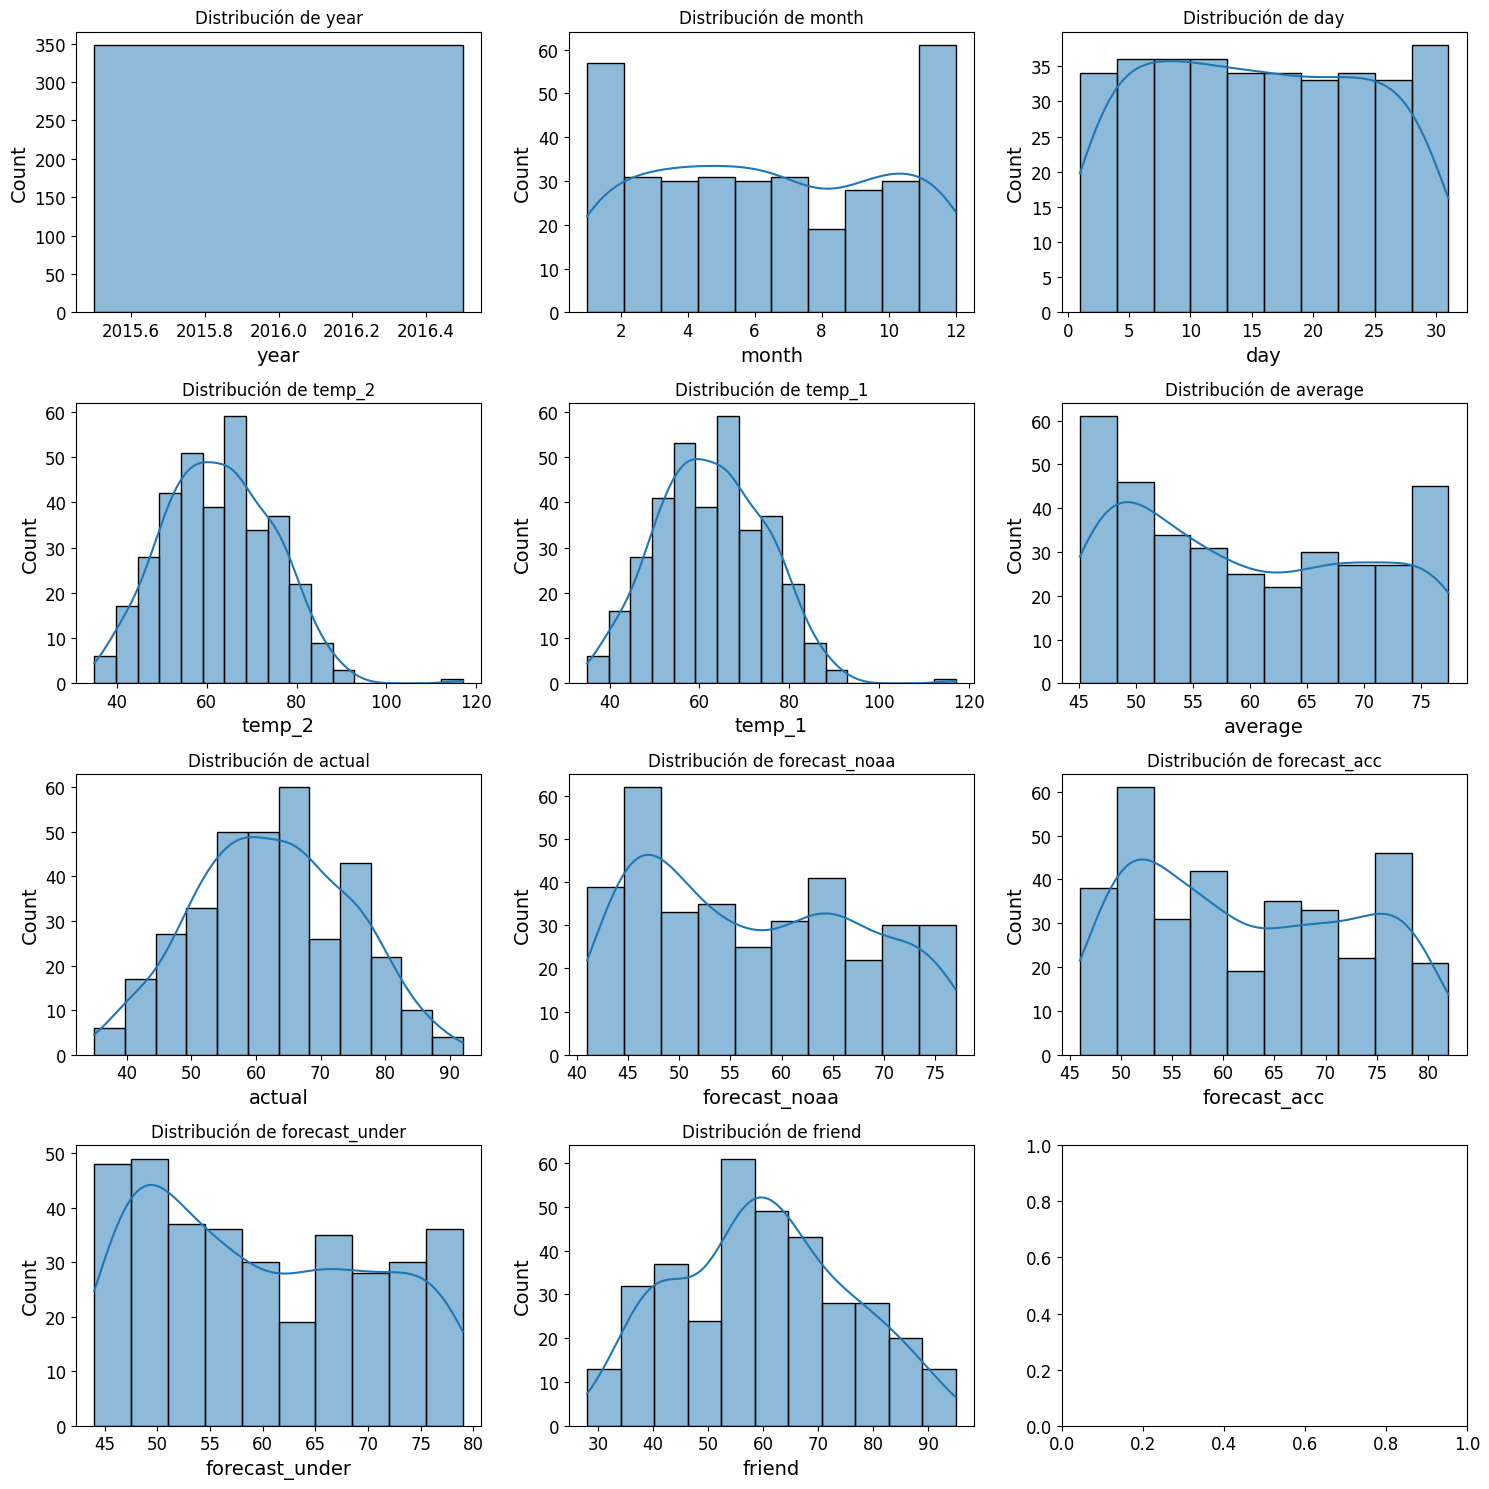

In [112]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()
for idx, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
    if idx < len(axes):
        sns.histplot(data=df, x=col, ax=axes[idx], kde=True)
        axes[idx].set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

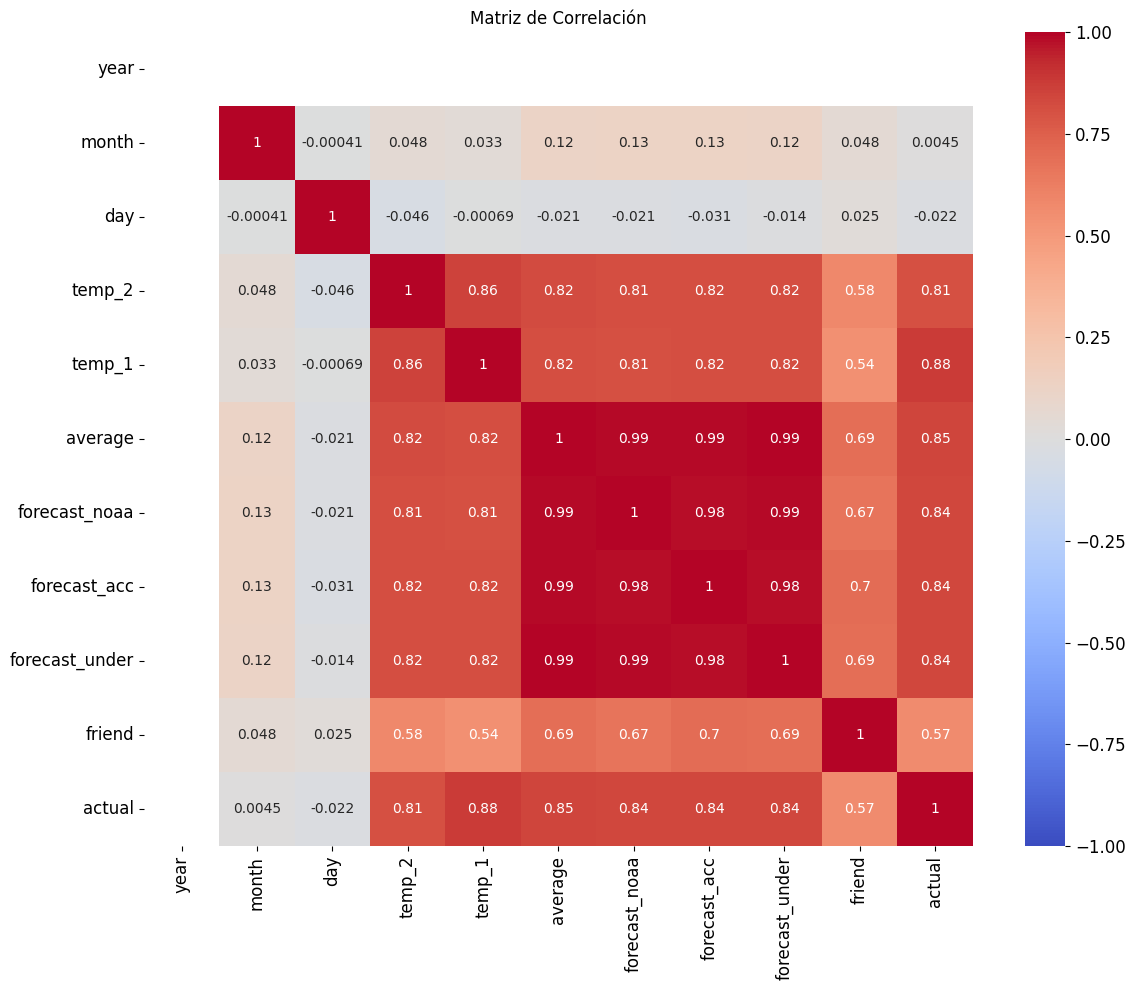

In [113]:
variables = ["year", "month", "day", "temp_2", "temp_1", "average", "forecast_noaa", "forecast_acc", "forecast_under", "friend", "actual"]

# Calculamos la matriz de correlación
correlation_matrix = df[variables].corr()
# Creamos un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

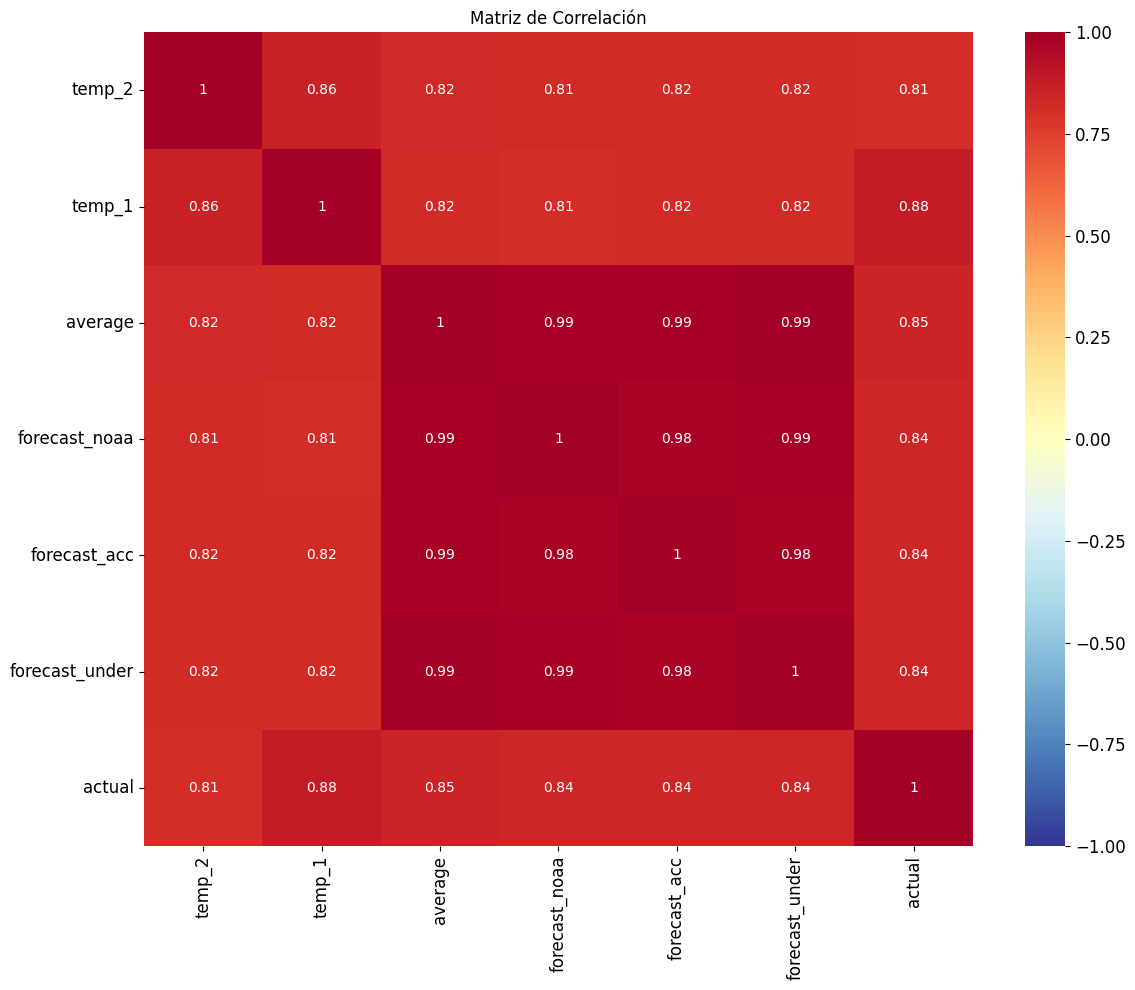

In [114]:
variables2 = ["temp_2", "temp_1", "average", "forecast_noaa", "forecast_acc", "forecast_under","actual"]
# Calculamos la matriz de correlación
correlation_matrix2 = df[variables2].corr()
# Creamos un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, center=0)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

Nos quedamos con las mejores correlaciones, despreciando: day, month, friend y year

### Modelo de Regresión con Decision Trees

### 3. Selecciona variables y divide en train y test

In [115]:
from sklearn.model_selection import train_test_split

if 'week' in df.columns:
    df = df.drop('week', axis=1)
    
X = np.array(df.drop(columns=['actual']))
y = np.array(df['actual'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42) 


### 4. Entrena el modelo


Profundidad del arbol: 2
Número de nodos terminales: 4


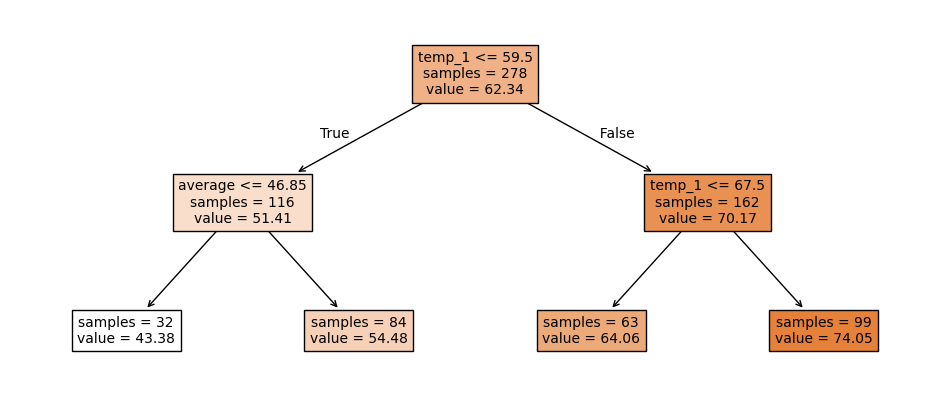

In [116]:
from sklearn.tree import plot_tree

modelo = DecisionTreeRegressor(
    max_depth=2,
    random_state=42
)

modelo.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(12,5))
print(f"Profundidad del arbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
    decision_tree = modelo, #
    feature_names = df.columns, #Nombres de las características (columnas)
    class_names = y_train,  #Nombre de las clases (para clasificación)
    filled = True,  #Colorea los nodos según la clase mayoritaria
    impurity = False, #muestra la impureza en cada nodo
    fontsize = 10,  #Tamaño de la fuente
    precision = 2, #Números decimales
    ax = ax #Eje de matplot donde dibujar
)

In [117]:
modelo.score(X_train,y_train) #La efectividad de la predicción

0.7929201827341514

Vamos a buscar el mejor valor con Cross Validation y GridSearchCV

In [118]:
from sklearn.model_selection import GridSearchCV

#param_grid = {'ccp_alpha':np.linspace(0,80,20)}
param_grid = {'max_depth':[3,4,5], 'min_samples_split': [2,3,4], 'min_samples_leaf': [2,3,4]}
#Búsqueda por validación cruzada
grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),#(
        #max_depth=None,
        #min_samples_split=2,
        #min_samples_leaf=1,
    #),
    param_grid= param_grid,
    cv = 10
)

grid.fit(X_train,y_train)
grid.best_params_


{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Profundidad del arbol: 3
Número de nodos terminales: 8


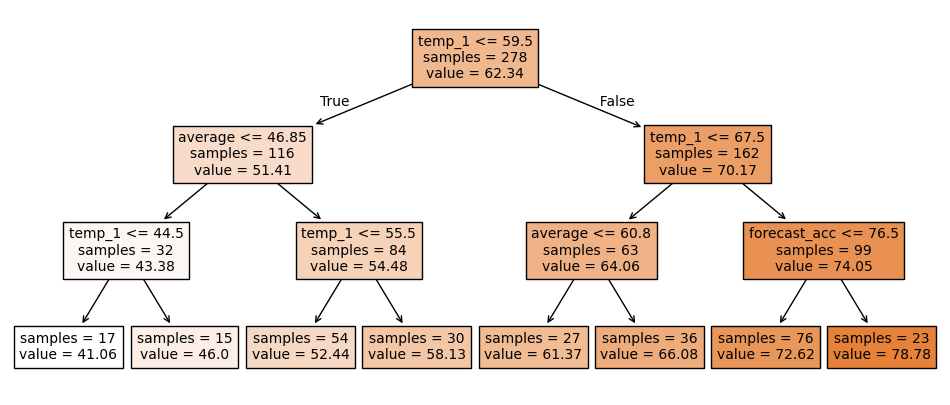

In [119]:
from sklearn.tree import plot_tree

modelo2 = DecisionTreeRegressor(
    random_state=42,
    max_depth=3,
    min_samples_leaf=4,
    min_samples_split=2
)

modelo2.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(12,5))
print(f"Profundidad del arbol: {modelo2.get_depth()}")
print(f"Número de nodos terminales: {modelo2.get_n_leaves()}")

plot = plot_tree(
    decision_tree = modelo2, #
    feature_names = df.columns, #Nombres de las características (columnas)
    class_names = y_train,  #Nombre de las clases (para clasificación)
    filled = True,  #Colorea los nodos según la clase mayoritaria
    impurity = False, #muestra la impureza en cada nodo
    fontsize = 10,  #Tamaño de la fuente
    precision = 2, #Números decimales
    ax = ax #Eje de matplot donde dibujar
)

In [120]:
modelo.score(X_train,y_train)

0.7929201827341514

### 5. Evaluación de tu modelo

Calcula el MAE, MAPE, MSE y RMSE.

In [121]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

prediction_train = modelo2.predict(X_train)
prediction_test = modelo2.predict(X_test)

#TRAIN
mae = mean_absolute_error(y_train,prediction_train)
mape = mean_absolute_percentage_error(y_train,prediction_train)*100
mse = mean_squared_error(y_train,prediction_train)
rmse = np.sqrt(mse)
print(f"mae = {mae}, mape = {mape}, mse = {mse}, rmse = {rmse}")

#TEST
mae = mean_absolute_error(y_test,prediction_test)
mape = mean_absolute_percentage_error(y_test,prediction_test)*100
mse = mean_squared_error(y_test,prediction_test)
rmse = np.sqrt(mse)
print(f"mae = {mae}, mape = {mape}, mse = {mse}, rmse = {rmse}")

mae = 3.64824877747553, mape = 5.843352963009388, mse = 22.031060168242668, rmse = 4.693725617059722
mae = 4.424444494299118, mape = 6.938377135428464, mse = 33.43673777437395, rmse = 5.782450844959596


### 6. Representa el árbol de decisión

### 7. Modifica el max_depth a 3 y vuelve a entrenarlo

### 8. Vuelve a evaluar tu modelo

### 9. Vuelve a representar su árbol

### 10. Utiliza un grid search con cross validation para hiperparametrizar tu modelo

### 11. Obten el `feature_importances` de cada variable en el último modelo

In [122]:
df

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,45,45,45.6,45,43,50,44,29
1,2016,1,2,44,45,45.7,44,41,50,44,61
2,2016,1,3,45,44,45.8,41,43,46,47,56
3,2016,1,4,44,41,45.9,40,44,48,46,53
4,2016,1,5,41,40,46.0,44,46,46,46,41
...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,47,41,50,47,47
344,2016,12,28,42,47,45.3,48,41,49,44,58
345,2016,12,29,47,48,45.3,48,43,50,45,65
346,2016,12,30,48,48,45.4,57,44,46,44,42


In [123]:
modelo2.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.88020751,
       0.09902152, 0.        , 0.        , 0.02077097, 0.        ])

### 12. Construye un nuevo modelo `DecisionTreeClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [124]:
X2 = df.drop(['actual'], axis=1)
yclasificacion = (df['actual'] > 69).astype(int)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, yclasificacion, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

clf = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)
clf.fit(X2_train, y2_train)

mejor_modelo = clf.best_estimator_
ypred = mejor_modelo.predict(X2_test)


from sklearn.metrics import classification_report, confusion_matrix

print(f"Mejores parámetros: {clf.best_params_}")
print(f"\nPrecisión en conjunto de prueba: {clf.score(X2_test, y2_test):.3f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y2_test, ypred))
print("\nReporte de clasificación:")
print(classification_report(y2_test, ypred))

Mejores parámetros: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

Precisión en conjunto de prueba: 0.886

Matriz de confusión:
[[45  8]
 [ 0 17]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        53
           1       0.68      1.00      0.81        17

    accuracy                           0.89        70
   macro avg       0.84      0.92      0.86        70
weighted avg       0.92      0.89      0.89        70

